<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Generate-Iris-data-for-model" data-toc-modified-id="Generate-Iris-data-for-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generate Iris data for model</a></span></li><li><span><a href="#Define-Model" data-toc-modified-id="Define-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define Model</a></span></li><li><span><a href="#Train-model-and-write-out-Predictions" data-toc-modified-id="Train-model-and-write-out-Predictions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train model and write out Predictions</a></span></li><li><span><a href="#Extract-model-weight-dynamics" data-toc-modified-id="Extract-model-weight-dynamics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Extract model weight dynamics</a></span></li><li><span><a href="#Analyze-Model-Dynamics-with-Gaussian-Process" data-toc-modified-id="Analyze-Model-Dynamics-with-Gaussian-Process-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Analyze Model Dynamics with Gaussian Process</a></span></li><li><span><a href="#Use-the-map-F-above-to-compute-the-Morse-graph" data-toc-modified-id="Use-the-map-F-above-to-compute-the-Morse-graph-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Use the map F above to compute the Morse graph</a></span></li></ul></div>

In [1]:
import CMGDB

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import numpy as np
import math
import csv
import pandas as pd



# Generate Iris data for model

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

def create_train_test(X,y):
    # One hot encoding
    enc = OneHotEncoder()
    Y = enc.fit_transform(y[:, np.newaxis]).toarray()

    # Scale data to have mean 0 and variance 1 
    # which is importance for convergence of the neural network
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split the data set into training and testing
    X_train, X_test, Y_train, Y_test = train_test_split(
        X_scaled, Y, test_size=0.5, random_state=2)
    return X_train, X_test, Y_train, Y_test

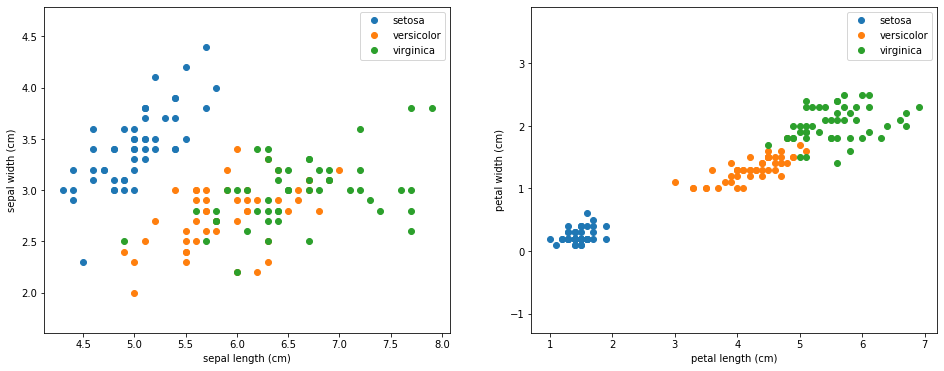

In [3]:
# Visualize the data sets
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.axis('equal')
plt.legend();

plt.subplot(1, 2, 2)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.axis('equal')
plt.legend();

# Define Model

In [4]:
# In order to ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras import initializers

from keras.models import Sequential
from keras.layers import Dense

X_train, X_test, Y_train, Y_test = create_train_test(X[:,[2,3]],y)

print("X",X_train.shape,X_test.shape)
print("Y",Y_train.shape,Y_test.shape)
initializer = initializers.RandomUniform(minval=-2, maxval=2, seed=None)

# define baseline model
def baseline_model(name):
    # create model
    model = Sequential(name=name)
    model.add(Dense(3, input_dim=X_train.shape[1],activation='softmax',kernel_initializer=initializer))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

baseline_model('model_test').summary()

X (75, 2) (75, 2)
Y (75, 3) (75, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


Using TensorFlow backend.


# Train model and write out Predictions

In [ ]:

##Update this to your own path
dirpath = '/Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights'

Y_preds = []
for i in range(100): #--> number of iterations
    name = 'model.'+str(i)
    cb_mc = ModelCheckpoint(os.path.join(dirpath,
                                         name+'-'+'{epoch:02d}-{val_loss:.2f}.hdf5'),
                            verbose=1,save_weights_only=True,)
    model = baseline_model(name)
    history_callback = model.fit(X_train, Y_train,batch_size=5,epochs=150,verbose=0,validation_data=(X_test, Y_test),callbacks=[cb_mc])
    score = model.evaluate(X_test, Y_test, verbose=0)
    Y_pred = pd.DataFrame(model.predict(X_test),columns=['p1','p2','p3'])
    Y_pred['class'] = Y_pred.idxmax(axis=1)
    Y_pred['model']=name
    Y_preds.append(Y_pred)
Y_predsDF = pd.concat(Y_preds)
Y_predsDF.to_csv(os.path.join(dirpath,'petal_predictions.csv')

In [ ]:
X_testDF = pd.DataFrame(X_test,columns=['feature1','feature2'])
Y_testDF = pd.DataFrame(Y_test,columns=['p1','p2','p3'])
Y_testDF['class_actual']=Y_testDF.idxmax(axis=1)
testDF =X_testDF.merge(Y_testDF,left_index=True,right_index=True)
testDF.drop(['p1','p2','p3'],axis=1,inplace=True)
Y_predsDF2=Y_predsDF.merge(testDF,left_index=True,right_index=True)

Y_predsDF2.to_csv(os.path.join(dirpath,'petal_predictions.csv')

# Extract model weight dynamics

In [ ]:
import os, h5py
def get_bias(name):
    if 'bias' in name:
        print(name)
        return name

def get_kernel(name):
    if 'kernel' in name:
        print(name)
        return name
    
model_weights={}
for fname in os.listdir(dirpath):
    if 'hdf5' in fname:
        print(fname)
        f = h5py.File(os.path.join(dirpath,fname) 'r')
        model_weights[fname]={}
#         model_weights[fname]['model_id']=fname[:-5]
        model_weights[fname]['model_id']=fname.split('-')[0]
        model_weights[fname]['epoch']=fname.split('-')[1]
        model_weights[fname]['val_loss']=fname.split('-')[2].replace('.hdf5','')
        bias_name = f.visit(get_bias)
        model_weights[fname]['bias']=f[bias_name][:]
        kernel_name = f.visit(get_kernel)
        model_weights[fname]['kernel']=f[kernel_name][:]
        
df_weights = pd.DataFrame.from_dict(model_weights).T

def flatten_array(kk):
    flat_list = [item for sublist in kk for item in sublist]
    return flat_list

def explode_to_cols(df,col_name):
    if len(df[col_name].iloc[0].shape)>1:
        df[col_name]=df[col_name].apply(flatten_array)
    return pd.DataFrame(df[col_name].tolist(),index=df.index,columns=[col_name+'_'+str(i) for i in range(len(df[col_name].iloc[0]))])

df_bias = explode_to_cols(df_weights,'bias')
df_kernel = explode_to_cols(df_weights,'kernel')

df_tot = pd.concat([df_weights,df_bias,df_kernel],axis=1,join='inner')

df_tot.drop(['bias','kernel'],axis=1,inplace=True)

#Write model dynamics out to file used by next section
df_tot.to_csv('/Volumes/GoogleDrive/Shared drives/Deep Chaos/data/petals_9_params/model_dynamics.csv') #--> file to read in

# Analyze Model Dynamics with Gaussian Process

In [17]:
# Define a Gaussian process
def GP(X_train, Y_train):
    # fit Gaussian Process with dataset X_train, Y_train
    kernel = RBF(0.5, (0.01, 2)) + WhiteKernel()
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(X_train, Y_train)
    return gp

In [18]:
# Load data from file
data = pd.read_csv('/Volumes/GoogleDrive/Shared drives/Deep Chaos/data/petals_9_params/model_dynamics.csv')
# data = np.loadtxt('PO_100.dat')
data.head(4)

,Unnamed: 0,model_id,epoch,val_loss,bias_0,bias_1,bias_2,kernel_0,kernel_1,kernel_2,kernel_3,kernel_4,kernel_5
0,model.53-109-0.51.hdf5,model.53,109,0.51,-0.184789,0.217462,-0.023773,0.745994,1.968086,0.936559,0.566623,0.913872,2.819305
1,model.50-65-0.73.hdf5,model.50,65,0.73,-0.071804,0.102633,-0.035136,0.084637,0.617425,2.207724,-0.221958,0.294776,-0.980537
2,model.98-111-0.38.hdf5,model.98,111,0.38,-0.330612,0.419091,-0.275485,0.029746,2.301435,1.395310,-1.463211,-1.562008,1.041306
3,model.61-103-1.08.hdf5,model.61,103,1.08,-0.244060,0.143224,0.219129,0.246848,-0.211677,0.194799,-0.245525,-0.203182,0.179519


In [19]:
print(data.columns)
print(data['epoch'].max())

Index(['Unnamed: 0', 'model_id', 'epoch', 'val_loss', 'bias_0', 'bias_1',
       'bias_2', 'kernel_0', 'kernel_1', 'kernel_2', 'kernel_3', 'kernel_4',
       'kernel_5'],
      dtype='object')
150


In [20]:
X=data.loc[data['epoch']==1,['kernel_0', 'kernel_1', 'kernel_2', 'kernel_3', 'kernel_4','kernel_5']].to_numpy()
Y=data.loc[data['epoch']==150,['kernel_0', 'kernel_1', 'kernel_2', 'kernel_3', 'kernel_4','kernel_5']].to_numpy()

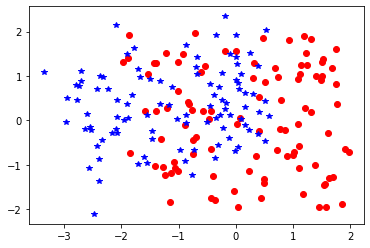

In [21]:
# Plot data
plt.plot(X[:,0], X[:,1], 'ro', Y[:,0], Y[:,1], 'b*');

In [22]:
X[0]

array([-1.01544929, -1.14266264, -0.91816193, -0.72508198,  1.45847797,
        0.52751118])

In [23]:
# Train a GP with the data above
gp = GP(X, Y)

In [24]:
# Use the GP to define a map F
# Notice that the GP takes lists as
# input and output, so we need to
# add the [] below
def F(X):
    return gp.predict([X])[0]

# Use the map F above to compute the Morse graph

In [25]:
# Define the parameters for CMGDB
lower_bounds = [data[x].min()-0.5 for x in data.columns if 'kernel' in x]
upper_bounds = [data[x].max()+0.5 for x in data.columns if 'kernel' in x]

phase_subdiv = 15

morse_fname = 'morse_sets.csv'

In [26]:
lower_bounds,upper_bounds

([-3.8510761260986333,
  -2.70108699798584,
  -2.4859955310821533,
  -3.672801971435547,
  -2.9787161350250244,
  -2.48372745513916],
 [2.467257857322693,
  2.8472516536712646,
  3.1275596618652344,
  2.368074655532837,
  2.8085203170776367,
  3.8227314949035645])

In [27]:
%%time
model = CMGDB.Model(phase_subdiv, lower_bounds, upper_bounds, F)
morse_graph, map_graph = CMGDB.ComputeMorseGraph(model)

CPU times: user 6min 44s, sys: 1.28 s, total: 6min 45s
Wall time: 6min 46s


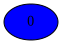

In [28]:
# Plot Morse graph
CMGDB.PlotMorseGraph(morse_graph)

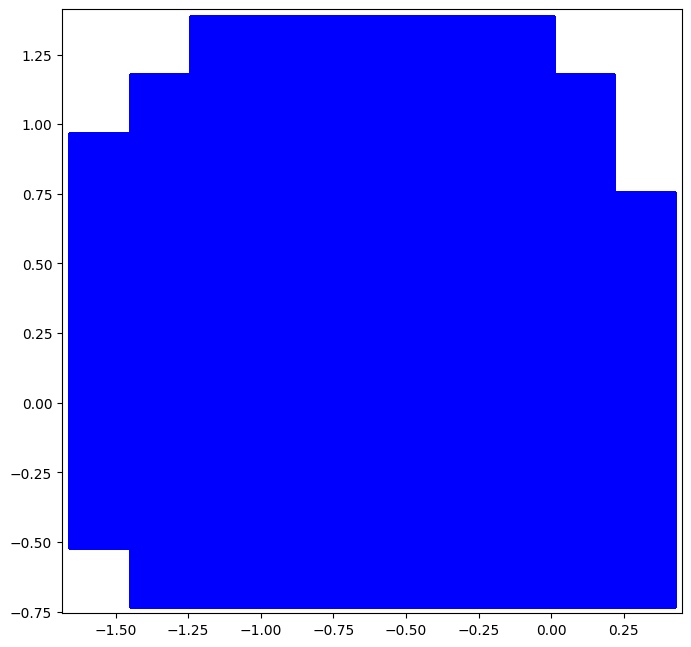

In [29]:
# Plot Morse sets
CMGDB.PlotMorseSets(morse_fname,proj_dims=[0,1])